In [1]:
# load Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import yfinance as yf

In [2]:
# Download Max History for S&P 500
print('Downloading S&P 500 data from Yahoo Finance...')
try:
    df = yf.download('^GSPC', period='max', progress=False, auto_adjust=False)
    
    # Handle potential MultiIndex columns (allows for easier reading)
    if isinstance(df.columns, pd.MultiIndex):
        # If columns are like ('Adj Close', '^GSPC'), drop the ticker level
        df.columns = df.columns.get_level_values(0)
        
    # Ensure index is datetime and sorted
    df.index = pd.to_datetime(df.index)
    df.sort_index(inplace=True)
    
    print(f'Loaded {len(df)} days of market data.')
    print(f'Data range: {df.index.min().date()} to {df.index.max().date()}')

except Exception as e:
    print(f'ERROR: Could not download data. {e}')
    sys.exit(1)

Loaded 24599 days of market data.
Data range: 1927-12-30 to 2025-12-04


In [3]:
# Resample to Annual Data ('YE' = Year End) to match our retirement simulation steps
# We take the last price of each year
df_yearly = df['Adj Close'].resample('YE').last()
df_yearly = df_yearly[:-1] #Current year is incomplete
# Calculate ANNUAL returns
#Drop the first value, no comparison
historical_returns = df_yearly.pct_change().dropna().values

print(f"Historical Data Processed: {len(historical_returns)} years")
print(f"Avg Annual Return: {np.mean(historical_returns):.3%}")
print(f"Standard Deviation: {np.std(historical_returns):.3%}")

Historical Data Processed: 97 years
Avg Annual Return: 8.012%
Standard Deviation: 18.940%


In [4]:
# User Defining Parameters
start_age = 25
retirement_age = 65
life_expectancy = 95 # Stress Test
years_to_sim = life_expectancy - start_age
starting_savings = 10000
annual_contribution = 10000 
spending_in_retirement = 60087 # Average yearly retirement spending (Investopedia)

# Risk Parameters
health_shock_prob = 0.01    # 1% chance per year of a major health issue (Google Gemini)
health_shock_cost = 5000   # Cost of that health issue (Google Gemini)

num_simulations = 5000

In [5]:
# Monte-Carlo simulation
# Rows = Simulation Number
# Columns = Year 
# (Index 0 is start year)
sim_matrix = np.zeros((num_simulations, years_to_sim + 1))
sim_matrix[:, 0] = starting_savings #Everyone starts with their original savings

# Create an array to track if a simulation has "failed" (ran out of money)
# We track this to stop withdrawing money if you are already broke
is_broke = np.zeros(num_simulations, dtype=bool)
for year in range(1, years_to_sim + 1): #BOOTSTRAPPING (sampling from our limited data)
    current_age = start_age + year
    market_return = np.random.choice(historical_returns, size=num_simulations, replace=True)
    
    # Health Catastrophe (Bernoulli)
    health_shocks = np.random.binomial(1, health_shock_prob, size=num_simulations)
    annual_health_costs = health_shocks * health_shock_cost
    
    # If age < 65: We add contributions (Saving phase)
    # If age >= 65: We subtract spending (Retirement phase)
    cash_flow = np.where(current_age < retirement_age, annual_contribution, -spending_in_retirement)
    
    # Update Balance
    prev_balance = sim_matrix[:, year - 1]
    
    # (Old * Growth) + Cash Flow - Health Costs
    new_balance = prev_balance * (1 + market_return) + cash_flow - annual_health_costs
    
    # No negative savings in this model
    new_balance = np.maximum(new_balance, 0)
    
    sim_matrix[:, year] = new_balance

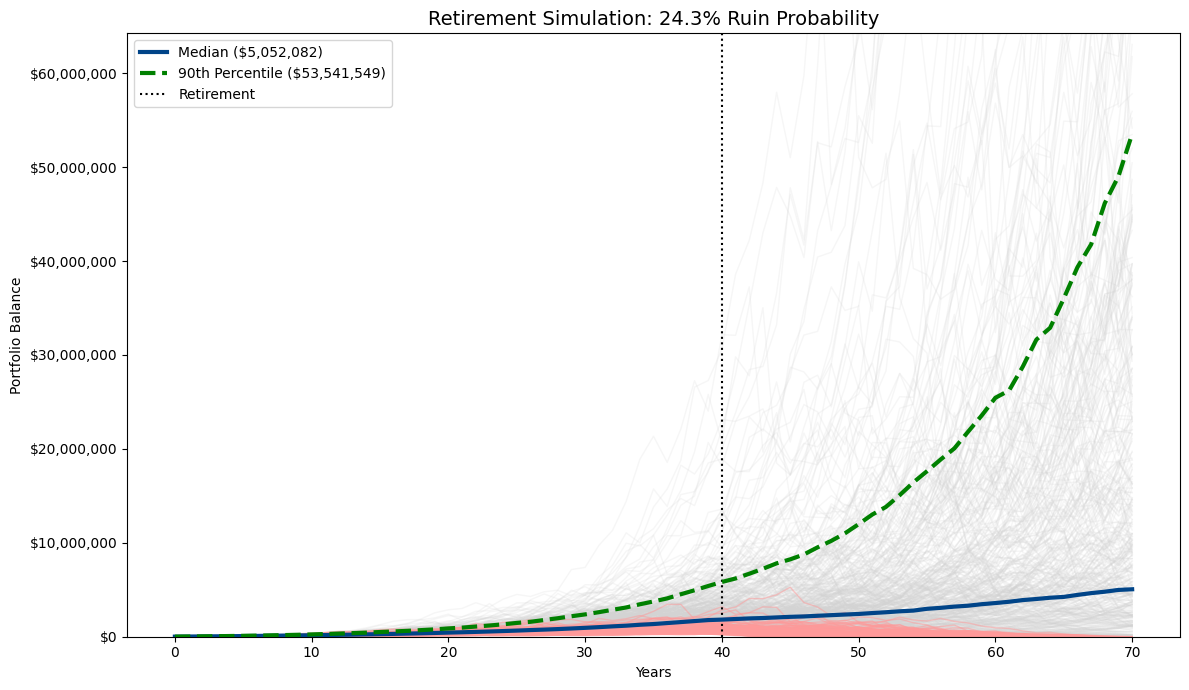

In [6]:
# Compute stats
median_path = np.median(sim_matrix, axis=0)
p90_path = np.percentile(sim_matrix, 90, axis=0)
prob_ruin = (sim_matrix[:, -1] == 0).mean()

# Visualization
fig, ax = plt.subplots(figsize=(12, 7))

# Plot a sample of individual paths for context
for path in sim_matrix[:500]:
    is_ruin = path[-1] == 0
    ax.plot(path, 
            color='#ff9999' if is_ruin else 'lightgray', 
            alpha=0.5 if is_ruin else 0.2, 
            linewidth=1, 
            zorder=1 if is_ruin else 0)

# Highlights
ax.plot(median_path, color='#004488', linewidth=3, zorder=10, 
        label=f'Median (${median_path[-1]:,.0f})')
ax.plot(p90_path, color='green', linewidth=3, linestyle='--', zorder=10, 
        label=f'90th Percentile (${p90_path[-1]:,.0f})')

ax.axvline(retirement_age - start_age, color='black', linestyle=':', label='Retirement')

# Formatting
ax.set_title(f'Retirement Simulation: {prob_ruin:.1%} Ruin Probability', fontsize=14)
ax.set_xlabel('Years')
ax.set_ylabel('Portfolio Balance')
ax.legend(loc='upper left')
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
ax.set_ylim(0, p90_path[-1] * 1.2)

plt.tight_layout()
plt.show()